In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
data = pd.read_csv('/workspaces/machine-learning-python-template/data/raw/AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
data.shape

(48895, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [6]:
data.nunique()

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

- Eliminar información irrelevante

En principio vemos que las columna id, host_id se pueden eliminar

host_name tambien se puede eliminar, ya que de entre todos los anuncios listados (48895), 48874 son distintos, es decir, solo hay 21 inmuebles que podrían tener el mismo propietario, 0,04% de la muestra. Por tanto, podemos predecir ya que la identidad del propietario no tiene mayor impacto en la cuestion.

En cuanto a la columna 'name', que vemos que contiene una pequeña descripción, nos encontramos en una situacion parecida, sin embargo,
puesto que se trata de un pequeño 'titular', podemos pensar que no tiene relacion con el precio, pero si es posible que este titular tenga
impacto sobre la demanda, lo que tiene impacto en el precio. 

In [7]:
data[['name', 'number_of_reviews', 'price', 'reviews_per_month', 'calculated_host_listings_count']]

,name,number_of_reviews,price,reviews_per_month,calculated_host_listings_count
0,Clean & quiet apt home by the park,9,149,0.21,6
1,Skylit Midtown Castle,45,225,0.38,2
2,THE VILLAGE OF HARLEM....NEW YORK !,0,150,NaN,1
3,Cozy Entire Floor of Brownstone,270,89,4.64,1
4,Entire Apt: Spacious Studio/Loft by central park,9,80,0.10,1
...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,0,70,NaN,2
48891,Affordable room in Bushwick/East Williamsburg,0,40,NaN,2
48892,Sunny Studio at Historical Neighborhood,0,115,NaN,1
48893,43rd St. Time Square-cozy single bed,0,55,NaN,6


In [8]:
data[['number_of_reviews', 'reviews_per_month', 'price']].corr()

,number_of_reviews,reviews_per_month,price
number_of_reviews,1.000000,0.549868,-0.047954
reviews_per_month,0.549868,1.000000,-0.030608
price,-0.047954,-0.030608,1.000000


Estudiando las columnas en conjunto podemos concluir que la columna 'name', no tendra practicamente interés para el modelo, ya que no oferce informacion relevante y a simplpe vista no parece tener correlacion entre el precio y el numero de visitas.
Además, sabiendo el mercado del que se trata, es decir inmuebles turísticos de Airbnb, podemos concluír que a la hora de hacer una búsqueda de alojamiento, el precio y la situación son las principales variables, y que el nombre apenas tiene interés ni llamada al 'click', y que en todo caso seria da descripcion detallada y sobre todo las fotografía lo que podría inclinar la balanza de la demanda.

In [9]:
data[['number_of_reviews','reviews_per_month', 'last_review']].isnull().mean()*100

number_of_reviews     0.000000
reviews_per_month    20.558339
last_review          20.558339
dtype: float64

La correlación entre 'number_of_reviews' y 'reviews_per_month' es positiva moderada (0.5499).
Puesto un mayor número total de reseñas también tengan una tasa de reseñas mensuales más alta, tienen una tasa del 20%, que es un nº considerable, y la información que ofrece no es relevante, ya que no tiene apenas correlación con el precio (variable clave), eliminaremos tambien estas columnas.

In [10]:
data.drop(['id', 'name', 'host_id', 'host_name', 'last_review', 'reviews_per_month'], axis=1, inplace=True)
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


 - Eliminar duplicados y nulos

In [11]:
# Buscamos duplicados
data.duplicated().sum()

0

In [12]:
# Buscamos valores nulos en todo el conjunto
data.isnull().any().any()

False

 - Análisis de estadísticas

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,48895.0,40.728949,0.054530,40.49979,40.69010,40.72307,40.763115,40.91306
longitude,48895.0,-73.952170,0.046157,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299
price,48895.0,152.720687,240.154170,0.00000,69.00000,106.00000,175.000000,10000.00000
minimum_nights,48895.0,7.029962,20.510550,1.00000,1.00000,3.00000,5.000000,1250.00000
number_of_reviews,48895.0,23.274466,44.550582,0.00000,1.00000,5.00000,24.000000,629.00000
calculated_host_listings_count,48895.0,7.143982,32.952519,1.00000,1.00000,1.00000,2.000000,327.00000
availability_365,48895.0,112.781327,131.622289,0.00000,0.00000,45.00000,227.000000,365.00000


 - Latitude y Longitude:
La media de la latitud es aproximadamente 40.73 y la media de la longitud es aproximadamente -73.95.
La desviación estándar para ambas características es relativamente baja, lo que sugiere que la mayoría de las ubicaciones se encuentran cerca de la media.
Los valores mínimos y máximos de latitud y longitud indican que todos los datos se encuentran dentro de un rango razonable para la ciudad de Nueva York.

 - Precio (Price):
El precio medio es de alrededor de $152, con una desviación estándar bastante alta de $240.
El rango de precios varía desde $0 hasta $10,000, lo que indica una amplia gama de precios en los alojamientos.
La mayoría de los precios se concentran por debajo de los $175, como lo demuestra el percentil 75.

 - Número mínimo de noches (Minimum Nights):
El promedio de noches mínimas es de aproximadamente 7, pero la desviación estándar es alta (aproximadamente 20.51), lo que indica una gran variabilidad en este aspecto.
El valor máximo de 1250 noches parece ser un valor atípico y podría ser el resultado de errores o entradas incorrectas en los datos.

 - Número de listados calculados por el anfitrión (Calculated Host Listings Count):
El promedio de listados calculados por el anfitrión es de alrededor de 7, pero la desviación estándar es muy alta, lo que sugiere una gran variabilidad en el número de listados por anfitrión.
El valor máximo de 327 parece ser un valor atípico y puede ser el resultado de anfitriones con múltiples propiedades en la plataforma.
Sin embargo, tal y como observamnos anetriormente, 'host_name', de entre todos los anuncios listados (48895), 48874 son distintos, es decir, solo hay 21 inmuebles que podrían tener el mismo propietario, con lo cual este valor máximo sigue pareciendo desproporcionado.

 - Disponibilidad durante el año (Availability 365):
La disponibilidad media durante el año es de aproximadamente 112 días, pero la desviación estándar es bastante alta, lo que indica una gran variabilidad en la disponibilidad.
El percentil 75 muestra que la mayoría de los alojamientos tienen una disponibilidad de menos de 227 días al año.

 - Limpieza variable objetivo

In [14]:
data[data['price'] == 0]
print((data['price'] == 0).sum())
data.drop(data[data['price'] == 0].index, axis=0, inplace=True)

# Observamos que hay 11 inmuebles a precio 0. Esto debe ser un error y es proporcionalmente nimio, limpiamos estas filas.

11


In [15]:
print((data['price'] > 500).sum())
print(f"{((data['price'] > 500).sum()) / len(data['price']) * 100}%")
data.drop(data[data['price'] > 500].index, axis=0, inplace=True)

# Lo mismo con los inmuebles de más de 500$, que suponen tan solo el 2% del conjunto, y sería mas efectivo observaros en un modelo 'de lujo'.

1044
2.135668112265772%


In [16]:
# Es posible que al filtrar y eliminar algunas filas del DataFrame original usando el método dropna() con inplace=True, el índice del DataFrame no se haya ajustado correctamente,
# lo que puede llevar a que el DataFrame resultante tenga índices adicionales que no corresponden a las filas eliminadas.

data.reset_index(drop=True, inplace=True)  # Restablece el índice del DataFrame después de eliminar filas no deseadas


In [17]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


 - Análisis de variables univariante

Análisis variables categóricas

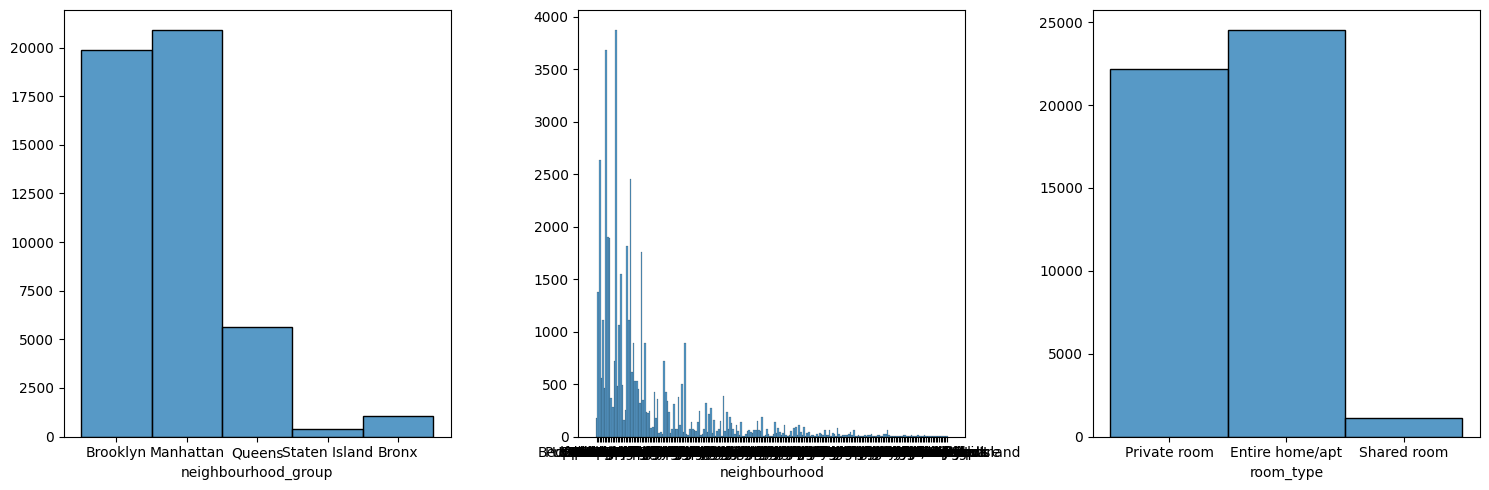

In [18]:
fig, axis = plt.subplots(1, 3, figsize = (15, 5))

# histograma múltiple
sns.histplot(ax = axis[0], data = data, x = "neighbourhood_group").set(ylabel=None)
sns.histplot(ax = axis[1], data = data, x = "neighbourhood").set(ylabel = None)
sns.histplot(ax = axis[2], data = data, x = "room_type").set(ylabel = None)


# Rotar nombres del eje x en el subplot neighbourhood

#axis[0, 1].set_xticklabels(axis[0, 1].get_xticklabels(), rotation=45)

# Ajustar el layout
plt.tight_layout()

plt.show()

Análisis variables numéricas

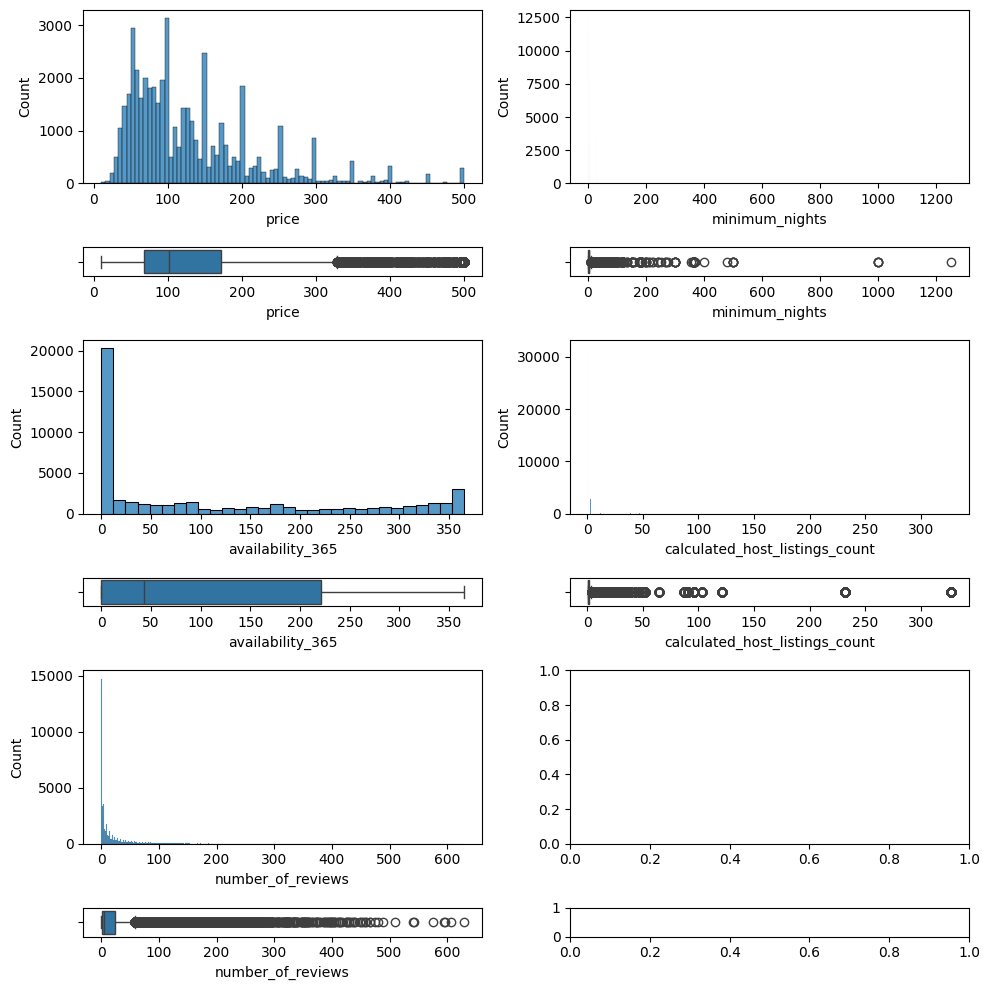

In [19]:
fig, axis = plt.subplots(6, 2, figsize = (10, 10), gridspec_kw = {"height_ratios": [6, 1, 6, 1, 6, 1]})

sns.histplot(ax = axis[0, 0], data = data, x = "price")
sns.boxplot(ax = axis[1, 0], data = data, x = "price")

sns.histplot(ax = axis[0, 1], data = data, x = "minimum_nights")
sns.boxplot(ax = axis[1, 1], data = data, x = "minimum_nights")

sns.histplot(ax = axis[2, 0], data = data, x = "availability_365")
sns.boxplot(ax = axis[3, 0], data = data, x = "availability_365")

sns.histplot(ax = axis[2, 1], data = data, x = "calculated_host_listings_count")
sns.boxplot(ax = axis[3, 1], data = data, x = "calculated_host_listings_count")

sns.histplot(ax = axis[4, 0], data = data, x = "number_of_reviews")
sns.boxplot(ax = axis[5, 0], data = data, x = "number_of_reviews")


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

 - Análisis multivariante

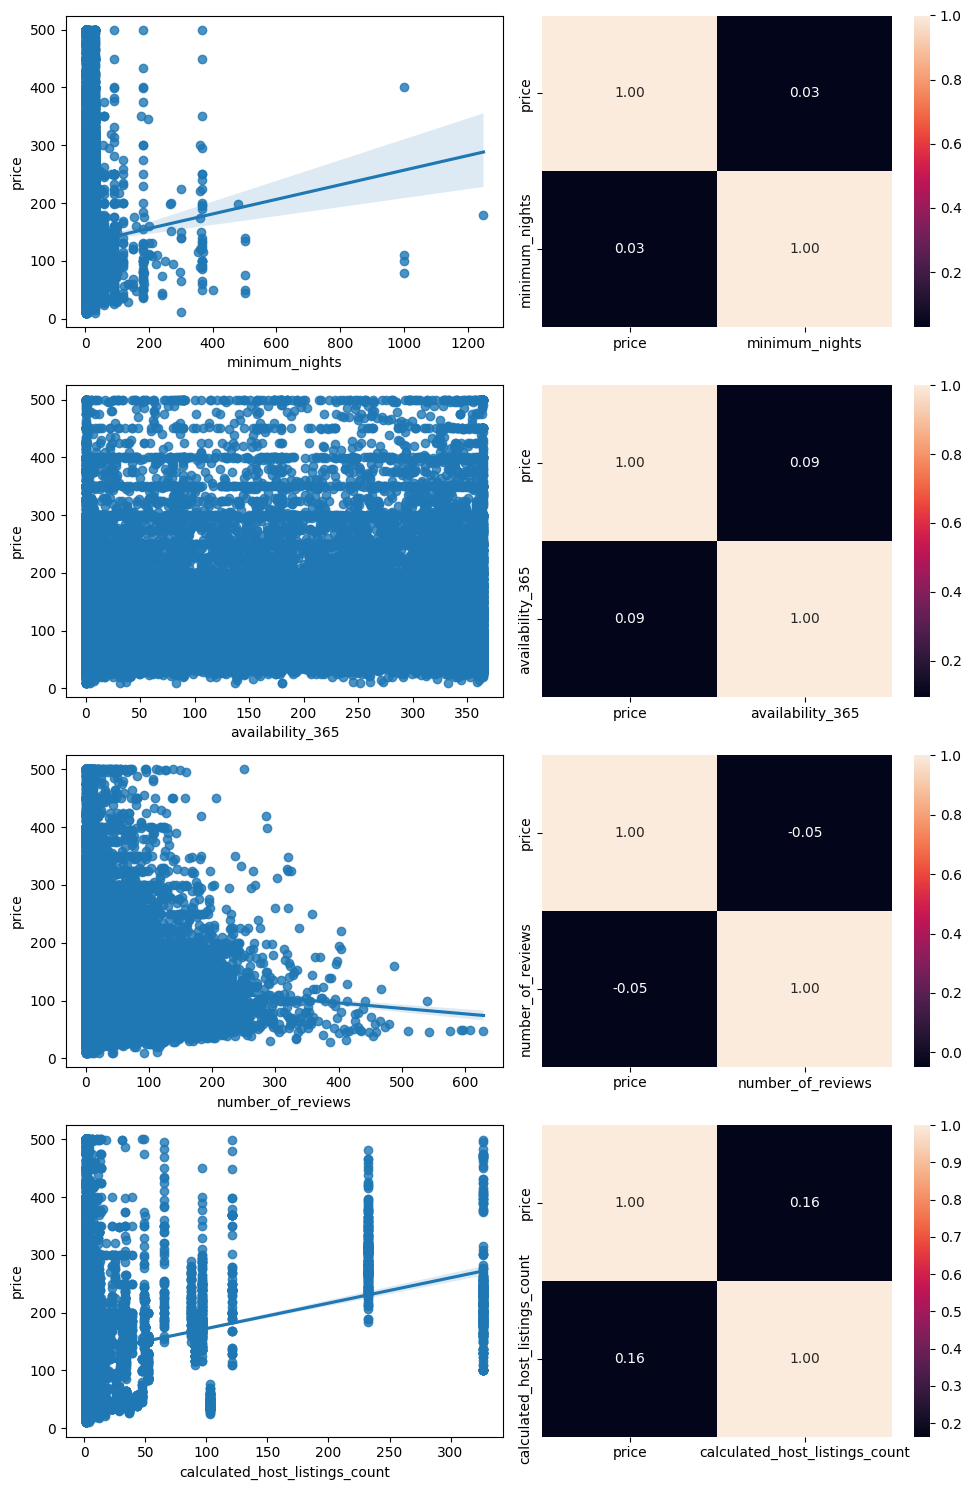

In [20]:
# Numerical - Numerical

fig, axis = plt.subplots(4, 2, figsize=(10, 15))

# Create Plates
sns.regplot(ax=axis[0, 0], data=data, x="minimum_nights", y="price")
sns.heatmap(data[["price", "minimum_nights"]].corr(), annot=True, fmt=".2f", ax=axis[0, 1])

sns.regplot(ax=axis[1, 0], data=data, x="availability_365", y="price")
sns.heatmap(data[["price", "availability_365"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

sns.regplot(ax=axis[2, 0], data=data, x="number_of_reviews", y="price")
sns.heatmap(data[["price", "number_of_reviews"]].corr(), annot=True, fmt=".2f", ax=axis[2, 1])

sns.regplot(ax=axis[3, 0], data=data, x="calculated_host_listings_count", y="price")
sns.heatmap(data[["price", "calculated_host_listings_count"]].corr(), annot=True, fmt=".2f", ax=axis[3, 1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

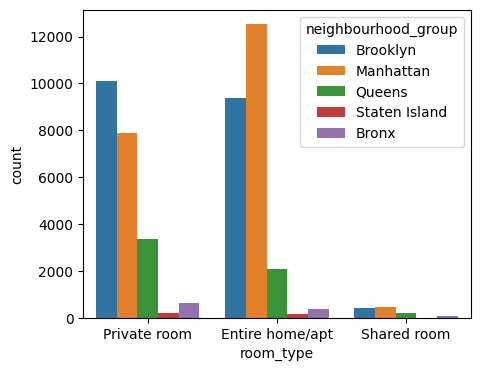

In [21]:
# Categorical-categorical analysis

fig, axis = plt.subplots(figsize = (5, 4))

sns.countplot(data = data, x = "room_type", hue = "neighbourhood_group")

# Show the plot
plt.show()

 - Codificación - Análisis de Correlación

El Target Encoder, también conocido como Target Mean Encoding o Leave-one-out Encoding, es una técnica de codificación utilizada en el preprocesamiento de datos para manejar variables categóricas. En lugar de asignar un número único a cada categoría, como en el caso de la codificación one-hot, el Target Encoder utiliza la información del valor objetivo (target) para asignar un valor numérico a cada categoría.

La idea principal detrás del Target Encoder es reemplazar cada categoría por la media del valor objetivo correspondiente a esa categoría. Esto puede ser útil en problemas de regresión o clasificación, donde queremos capturar la relación entre las variables categóricas y el valor objetivo.

In [22]:
columns_to_encode = ['neighbourhood_group', 'neighbourhood', 'room_type']

# Inicializa el codificador
encoder = ce.TargetEncoder(cols=columns_to_encode)

# Ajusta y transforma los datos
data_codif = encoder.fit_transform(data[columns_to_encode], data['price'])  # 'price' es la variable objetivo

# Elimina las columnas originales del DataFrame
data_num = data.drop(columns=columns_to_encode)

# Concatena las columnas codificadas con el DataFrame original
data_encoded = pd.concat([data_num, data_codif], axis=1)
data_encoded.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group,neighbourhood,room_type
0,40.64749,-73.97237,149,1,9,6,365,112.679251,90.402307,81.821744
1,40.75362,-73.98377,225,1,45,2,355,163.255805,219.057887,179.742882
2,40.80902,-73.94190,150,3,0,1,365,163.255805,108.736982,81.821744
3,40.68514,-73.95976,89,1,270,1,194,112.679251,135.377698,179.742882
4,40.79851,-73.94399,80,10,9,1,0,163.255805,118.694319,179.742882


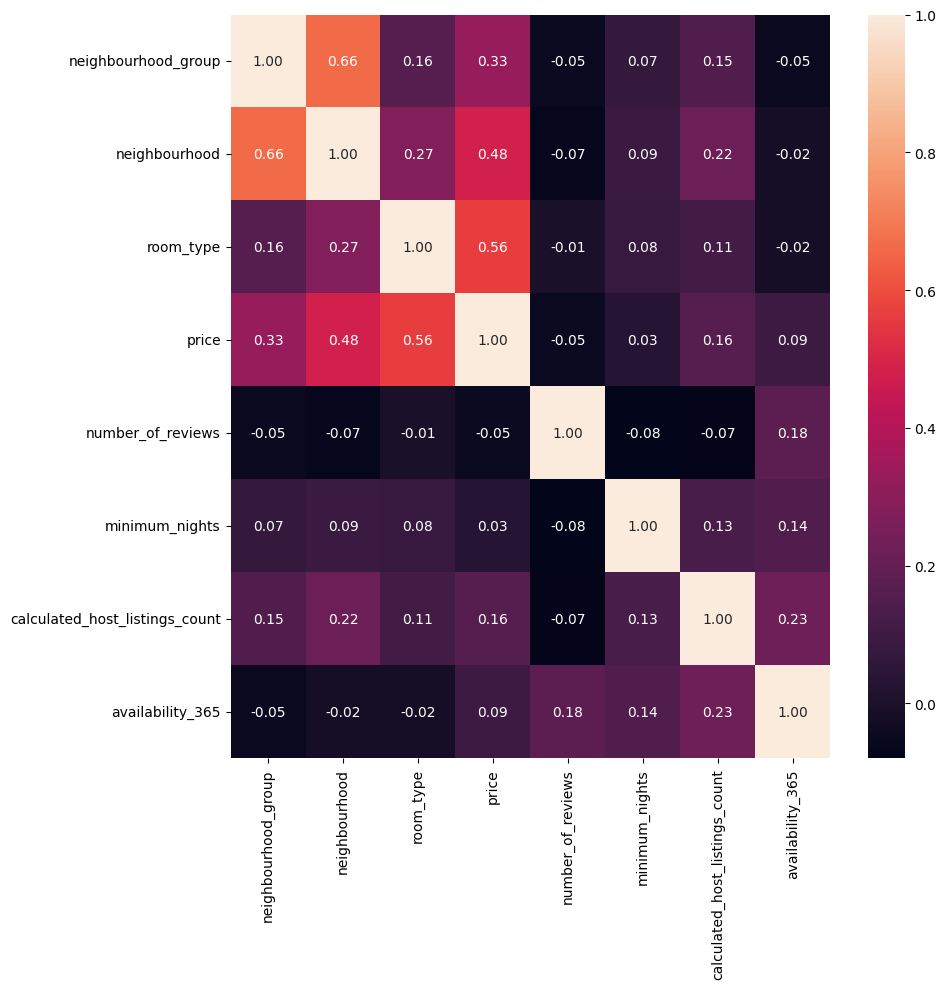

In [23]:
fig, axes = plt.subplots(figsize=(10, 10))

sns.heatmap(data_encoded[["neighbourhood_group", "neighbourhood", "room_type", "price", "number_of_reviews",
                  "minimum_nights", "calculated_host_listings_count", "availability_365"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

# Draw Plot
plt.show()

 - Distancia de Cook (Análisis de influencia)

In [24]:
# Variables independientes/dependiente
X = data_encoded.drop(['price'], axis=1)
y = data_encoded['price']

# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

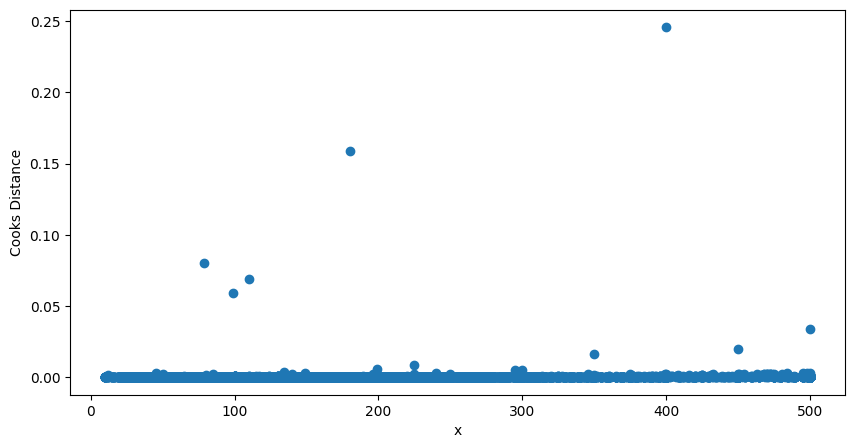

In [25]:
plt.figure(figsize=(10, 5))
plt.scatter(data.price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [26]:
np.where(cooks_distance[0]>0.05)
data.iloc[[2805,  5623, 13148, 25849, 37903]]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
2805,Manhattan,Battery Park City,40.71239,-74.01620,Entire home/apt,400,1000,0,1,362
5623,Manhattan,Greenwich Village,40.73293,-73.99782,Entire home/apt,180,1250,2,1,365
13148,Manhattan,Harlem,40.82915,-73.94034,Entire home/apt,99,999,2,1,42
25849,Brooklyn,Williamsburg,40.71772,-73.95059,Private room,79,999,24,6,249
37903,Manhattan,Greenwich Village,40.73094,-73.99900,Shared room,110,999,0,1,365


In [27]:
data_encoded.corr()
data[['minimum_nights', 'price']].corr()

,minimum_nights,price
minimum_nights,1.000000,0.029189
price,0.029189,1.000000


Observamos que las metricas con una influencia desmesurada tienen una cantidad de noches mínimas demasiado grandes, y la variable en cuestión apenas tiene relación con la variable objetivo, por lo que optams por eliminarla.

In [28]:
data.drop('minimum_nights', axis=1, inplace=True)
data_encoded.drop('minimum_nights', axis=1, inplace=True)

In [29]:
data_encoded.head()

,latitude,longitude,price,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group,neighbourhood,room_type
0,40.64749,-73.97237,149,9,6,365,112.679251,90.402307,81.821744
1,40.75362,-73.98377,225,45,2,355,163.255805,219.057887,179.742882
2,40.80902,-73.94190,150,0,1,365,163.255805,108.736982,81.821744
3,40.68514,-73.95976,89,270,1,194,112.679251,135.377698,179.742882
4,40.79851,-73.94399,80,9,1,0,163.255805,118.694319,179.742882


 - Análisis de outlayers

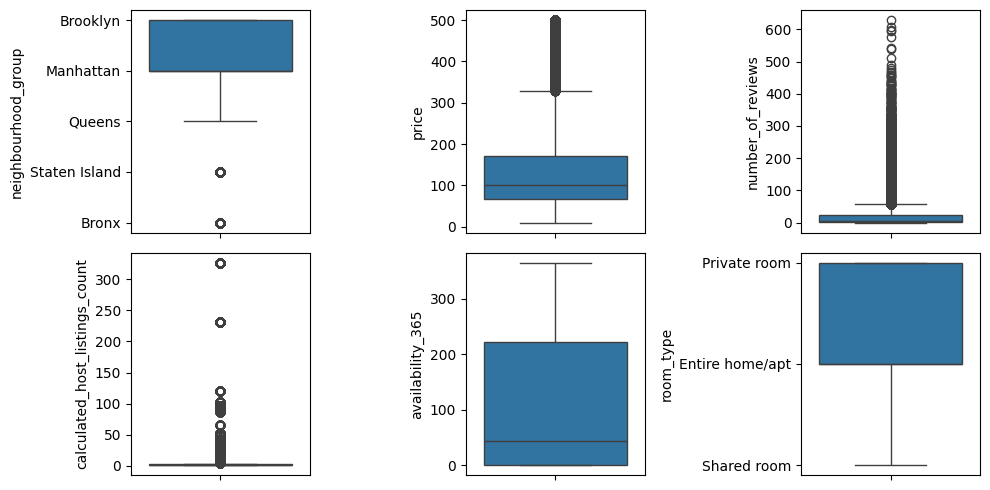

In [30]:
fig, axes = plt.subplots(2, 3, figsize = (10, 5))

sns.boxplot(ax = axes[0, 0], data = data, y = "neighbourhood_group")
sns.boxplot(ax = axes[0, 1], data = data, y = "price")
sns.boxplot(ax = axes[0, 2], data = data, y = "number_of_reviews")

sns.boxplot(ax = axes[1, 0], data = data, y = "calculated_host_listings_count")
sns.boxplot(ax = axes[1, 1], data = data, y = "availability_365")
sns.boxplot(ax = axes[1, 2], data = data, y = "room_type")

plt.tight_layout()

plt.show()

In [31]:
data[data['availability_365'] == 0]
print((data['availability_365'] == 0).sum())

17322


In [32]:
data[['availability_365', 'price']].corr()

,availability_365,price
availability_365,1.00000,0.09463
price,0.09463,1.00000


Observamos que hay una cantidad considerable de mediciones a 0 en la variable de disponibilidad, lo cual debe ser érroneo. Eliminando las filas con inmuebles que no están disponibles perderíamos demasiados datos, por lo que, considerando la poca correlación con la variable objetivo, la eliminaremos.
Para las columnas 'number_of_reviews' y 'calculated_host_listings_count', optaremos por windsorizar los datos para reducir las mediciones extremas.

In [45]:
data_encoded.drop(['availability_365'], axis=1, inplace=True)
data.drop(['availability_365'], axis=1, inplace=True)
data_encoded.head()

,latitude,longitude,price,number_of_reviews,calculated_host_listings_count,neighbourhood_group,neighbourhood,room_type
0,40.64749,-73.97237,149,9,6,112.679251,90.402307,81.821744
1,40.75362,-73.98377,225,45,2,163.255805,219.057887,179.742882
2,40.80902,-73.94190,150,0,1,163.255805,108.736982,81.821744
3,40.68514,-73.95976,89,270,1,112.679251,135.377698,179.742882
4,40.79851,-73.94399,80,9,1,163.255805,118.694319,179.742882


In [47]:
data_encoded.apply(lambda x: x.skew())

latitude                          0.247811
longitude                         1.274570
price                             1.558334
number_of_reviews                 3.661465
calculated_host_listings_count    7.956470
neighbourhood_group               0.040792
neighbourhood                     0.589588
room_type                        -0.059968
dtype: float64

In [48]:
review_stats = data_encoded["number_of_reviews"].describe()
review_stats

count    47840.000000
mean        23.544147
std         44.821842
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: number_of_reviews, dtype: float64

In [49]:
# IQR for number_of_reviews

review_iqr = review_stats["75%"] - review_stats["25%"]

upper_limit = review_stats["75%"] + 1.5 * review_iqr
lower_limit = review_stats["25%"] - 1.5 * review_iqr

print(f"The upper and lower limits for finding outliers are {round(upper_limit, 2)} and {round(lower_limit, 2)}, with an interquartile range of {round(review_iqr, 2)}")

The upper and lower limits for finding outliers are 58.5 and -33.5, with an interquartile range of 23.0


In [50]:
data_encoded = data_encoded[(data_encoded["number_of_reviews"] >= lower_limit) & (data_encoded["number_of_reviews"] <= upper_limit)]


In [51]:
hostlist_stats = data_encoded["calculated_host_listings_count"].describe()
hostlist_stats

count    41864.000000
mean         7.792590
std         34.956639
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        327.000000
Name: calculated_host_listings_count, dtype: float64

In [52]:
# IQR for calculated_host_listings_count

hostlist_iqr = hostlist_stats["75%"] - hostlist_stats["25%"]

upper_limit = hostlist_stats["75%"] + 1.5 * hostlist_iqr
lower_limit = hostlist_stats["25%"] - 1.5 * hostlist_iqr

print(f"The upper and lower limits for finding outliers are {round(upper_limit, 2)} and {round(lower_limit, 2)}, with an interquartile range of {round(hostlist_iqr, 2)}")

The upper and lower limits for finding outliers are 3.5 and -0.5, with an interquartile range of 1.0


In [53]:
data_encoded = data_encoded[(data_encoded["calculated_host_listings_count"] >= lower_limit) & (data_encoded["calculated_host_listings_count"] <= upper_limit)]


In [54]:
data_encoded.shape

(35770, 8)

In [56]:
data_encoded.head()

,latitude,longitude,price,number_of_reviews,calculated_host_listings_count,neighbourhood_group,neighbourhood,room_type
1,40.75362,-73.98377,225,45,2,163.255805,219.057887,179.742882
2,40.80902,-73.94190,150,0,1,163.255805,108.736982,81.821744
4,40.79851,-73.94399,80,9,1,163.255805,118.694319,179.742882
6,40.68688,-73.95596,60,49,1,112.679251,97.761827,81.821744
10,40.80316,-73.96545,135,53,1,163.255805,162.809599,179.742882


La variable objetivo 'price' la llevaremos a escala logaritmica, ya que eliminamos tanto los 0 como los valores muy altos, pero aún sigue habiendo valores atípicos altos que no corresponden con el grueso de la muestra.

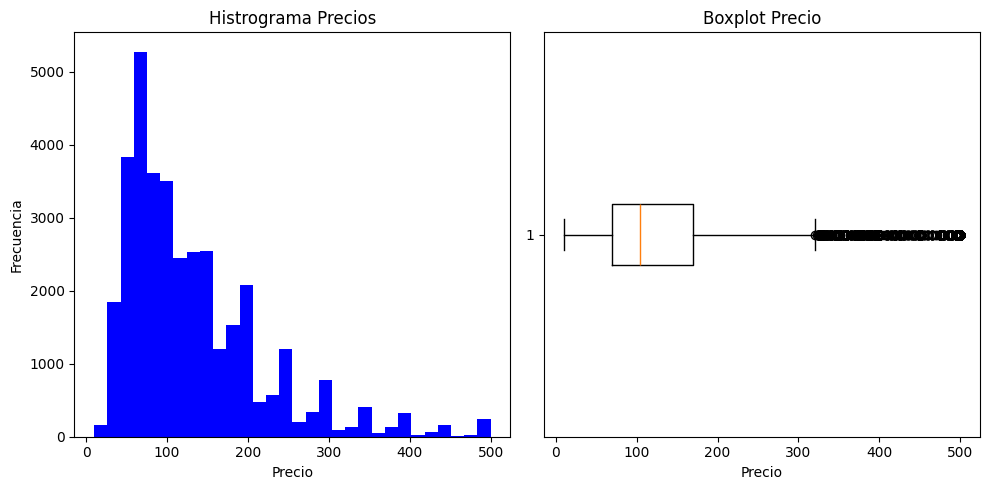

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(data_encoded['price'], bins=30, color='blue')
ax[0].set_title("Histrograma Precios")
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(data_encoded['price'], vert=False)
ax[1].set_title("Boxplot Precio")
ax[1].set_xlabel("Precio")

plt.tight_layout()
plt.show()

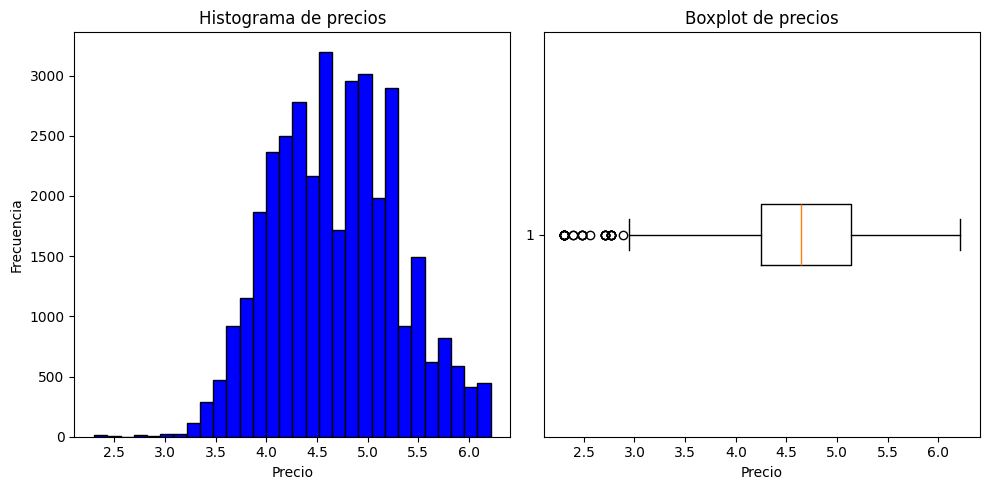

In [62]:
data_encoded['price_log'] = np.log(data_encoded.price)

# figura -subplots (histograma y boxplot)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(data_encoded['price_log'], bins=30, color='blue', edgecolor='black')
ax[0].set_title('Histograma de precios')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(data_encoded['price_log'], vert=False)
ax[1].set_title('Boxplot de precios')
ax[1].set_xlabel('Precio')

plt.tight_layout()
plt.show()

In [63]:
data_encoded.apply(lambda x: x.skew())

latitude                          0.289958
longitude                         1.280461
price                             1.595096
number_of_reviews                 1.734137
calculated_host_listings_count    1.973910
neighbourhood_group               0.076490
neighbourhood                     0.620208
room_type                        -0.096106
price_log                         0.098718
dtype: float64

In [64]:
data_encoded.head()

,latitude,longitude,price,number_of_reviews,calculated_host_listings_count,neighbourhood_group,neighbourhood,room_type,price_log
1,40.75362,-73.98377,225,45,2,163.255805,219.057887,179.742882,5.416100
2,40.80902,-73.94190,150,0,1,163.255805,108.736982,81.821744,5.010635
4,40.79851,-73.94399,80,9,1,163.255805,118.694319,179.742882,4.382027
6,40.68688,-73.95596,60,49,1,112.679251,97.761827,81.821744,4.094345
10,40.80316,-73.96545,135,53,1,163.255805,162.809599,179.742882,4.905275


In [65]:
corr = data_encoded.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)

,latitude,longitude,price,number_of_reviews,calculated_host_listings_count,neighbourhood_group,neighbourhood,room_type,price_log
latitude,1.000,0.102,0.058,-0.016,-0.038,0.483,0.136,-0.017,0.065
longitude,0.102,1.000,-0.274,0.051,0.104,-0.501,-0.577,-0.174,-0.311
price,0.058,-0.274,1.000,-0.015,-0.107,0.298,0.457,0.551,0.932
number_of_reviews,-0.016,0.051,-0.015,1.000,0.122,-0.033,-0.049,0.036,0.003
calculated_host_listings_count,-0.038,0.104,-0.107,0.122,1.000,-0.092,-0.127,-0.198,-0.130
neighbourhood_group,0.483,-0.501,0.298,-0.033,-0.092,1.000,0.633,0.141,0.333
neighbourhood,0.136,-0.577,0.457,-0.049,-0.127,0.633,1.000,0.251,0.496
room_type,-0.017,-0.174,0.551,0.036,-0.198,0.141,0.251,1.000,0.643
price_log,0.065,-0.311,0.932,0.003,-0.130,0.333,0.496,0.643,1.000


In [67]:
corr[corr.price_log.abs()<0.2].index

Index(['latitude', 'number_of_reviews', 'calculated_host_listings_count'], dtype='object')

In [69]:
corr[corr.price_log.abs()>0.3].index

Index(['longitude', 'price', 'neighbourhood_group', 'neighbourhood',
       'room_type', 'price_log'],
      dtype='object')

In [70]:
corr.price_log

latitude                          0.064757
longitude                        -0.311025
price                             0.932319
number_of_reviews                 0.003101
calculated_host_listings_count   -0.129633
neighbourhood_group               0.333072
neighbourhood                     0.496427
room_type                         0.643158
price_log                         1.000000
Name: price_log, dtype: float64

Observamos que no hay apenas correlacion con la variable 'number_of_reviews', por lo que finalmente optamos por eliminarla. Eliminamos a la vez la columna 'price', ya que la tenemos pasada a logaritmica.

In [71]:
data_encoded.drop(['number_of_reviews'], axis=1, inplace=True)

In [73]:
data_encoded.drop(['price'], axis=1, inplace=True)

 - Factor de Inflación de la Varianza (VIF)

Medida que cuantifica el incremento de la varianza de un coeficiente de regresión por la multicolinealidad entre las variables independientes.
El cálculo del VIF se realiza para cada variable independiente en relación con las demás.

Un valor alto de VIF indica una alta multicolinealidad entre esa variable y las demás.

In [77]:
corr = data_encoded.corr()
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=data_encoded.columns)
vif

latitude                           6.176719
longitude                          8.941655
calculated_host_listings_count     1.283052
neighbourhood_group               21.654939
neighbourhood                     14.761665
room_type                          7.354044
price_log                         12.476179
dtype: float64

In [78]:
data_encoded.head()

,latitude,longitude,calculated_host_listings_count,neighbourhood_group,neighbourhood,room_type,price_log
1,40.75362,-73.98377,2,163.255805,219.057887,179.742882,5.416100
2,40.80902,-73.94190,1,163.255805,108.736982,81.821744,5.010635
4,40.79851,-73.94399,1,163.255805,118.694319,179.742882,4.382027
6,40.68688,-73.95596,1,112.679251,97.761827,81.821744,4.094345
10,40.80316,-73.96545,1,163.255805,162.809599,179.742882,4.905275


 - Escalado de valores

In [81]:
from sklearn.preprocessing import MinMaxScaler

num_variables = ["latitude", "longitude", "calculated_host_listings_count", 
                 "neighbourhood", "neighbourhood_group", "room_type"]
scaler = MinMaxScaler()
scal_features = scaler.fit_transform(data_encoded[num_variables])
data_scal = pd.DataFrame(scal_features, index = data_encoded.index, columns = num_variables)
data_scal["price_log"] = data_encoded["price_log"]
data_scal.head()

,latitude,longitude,calculated_host_listings_count,neighbourhood,neighbourhood_group,room_type,price_log
1,0.614199,0.490469,0.5,0.760414,1.000000,1.000000,5.416100
2,0.748252,0.569257,0.0,0.232833,1.000000,0.156682,5.010635
4,0.722820,0.565324,0.0,0.280452,1.000000,1.000000,4.382027
6,0.452706,0.542800,0.0,0.180348,0.378954,0.156682,4.094345
10,0.734072,0.524942,0.0,0.491421,1.000000,1.000000,4.905275
